### **INITIALIZATION:**
- I use these 3 lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [332]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

###**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [333]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l

from d2l import torch as d2l
from IPython import display
import matplotlib.pyplot as plt

import os
import torch                                     
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F

PROJECT_ROOT_DIR = "."
ID = "STYLE"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

### **READING CONTENT AND STYLE IMAGES:**
- I will initialize the composite image as a content image. The content image is the only variable that needs to be updated in the style transfer process. Now, I will read the content and style images. I will inspect the coordinate axes of images.  

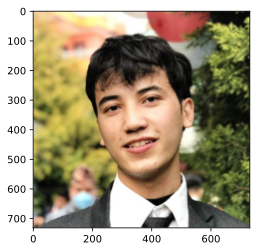

In [334]:
#@ READING THE CONTENT IMAGE:
PATH = "/content/drive/MyDrive/Colab Notebooks/NST/Thinam 100.jpg"      # Path to the Image. 
d2l.set_figsize((4, 4))
content_img = d2l.Image.open(PATH)                                      # Reading the Image. 
d2l.plt.imshow(content_img);                                            # Inspecting the Image. 

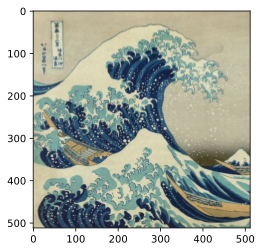

In [335]:
#@ READING THE STYLE IMAGE: 
PATH = "/content/drive/MyDrive/Colab Notebooks/NST/output_4_0.png"                  # Path to the Image. 
d2l.set_figsize((4, 4))
style_img = d2l.Image.open(PATH)                                                    # Reading the Image. 
d2l.plt.imshow(style_img);                                                          # Inspecting the Image. 

### **PREPROCESSING AND POSTPROCESSING:**
- I will define the functions for image preprocessing and postprocessing. The preprocess function normalizes each of the three RGB channels of the input images and transforms the results to a format that can be input to the CNN. The postprocess function restores the pixel values in the output image to their original values before normalization. 

In [336]:
#@ INITIALIZATION OF PARAMETERS: 
rgb_mean = torch.tensor([0.485, 0.456, 0.406])                                 # Initializing RGB Mean. 
rgb_std = torch.tensor([0.229, 0.224, 0.225])                                  # Initializing RGB Standard Deviation. 

#@ DEFINING PREPROCESSING FUNCTION:
def preprocess(img, img_shape):
  transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(img_shape),                          # Reshaping the Image. 
            torchvision.transforms.ToTensor(),                                 # Converting into Tensors. 
            torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])     # Normalization of the Image. 
  return transforms(img).unsqueeze(0)

#@ DEFINING POSTPROCESSING FUNCTION: 
def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)           # Implementing Clamp Function. 
  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))             # Converting to PIL Image. 

### **EXTRACTING FEATURES:**
- I will use VGG-19 model pretrained on ImageNet dataset to extract image features. I will select the outputs of different layers from the VGG Neural Network for matching local and global styles. 

In [337]:
#@ EXTRACTING FEATURES: 
pretrained_net = torchvision.models.vgg19(pretrained=True)                    # Initializing Pretrained Neural Network. 
style_layers, content_layers = [0, 5, 10, 19, 28], [25]                       # Initializing Parameters. 
net = nn.Sequential(*[pretrained_net.features[i] \
                      for i in range(max(content_layers+style_layers) + 1)])  # Initializing Pretrained Neural Network. 

In [338]:
#@ FUNCTION FOR EXTRACTING FEATURES: 
def extract_features(X, content_layers, style_layers):                         # Function for Extracting Features. 
  contents, styles = [], []                                                    # Initialization. 
  for i in range(len(net)):
    X = net[i](X)
    for i in style_layers: 
      styles.append(X)
    for i in content_layers: 
      contents.append(X)
  return contents, styles

#@ FUNCTION FOR EXTRACTING CONTENTS FEATURES: 
def get_contents(image_shape, device):                                         # Extracting Contents Features. 
  content_X = preprocess(content_img, image_shape).to(device)                  # Implementation of Preprocess Function.   
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)    # Implementation of Extract Features Function. 
  return content_X, contents_Y

#@ FUNCTION FOR EXTRACTING STYLE FEATURES: 
def get_styles(image_shape, device):                                           # Extracting Styles Features. 
  style_X = preprocess(style_img, image_shape).to(device)                      # Implementation of Preprocess Function. 
  _, styles_Y = extract_features(style_X, content_layers, style_layers)        # Implementation of Extract Features Function. 
  return style_X, styles_Y

### **LOSS FUNCTIONS:**
- I will define the loss functions which are used for style transfer. The loss functions include content loss, style loss and total variation loss. 

In [339]:
#@ DEFINING CONTENT LOSS FUNCTION: 
def content_loss(y_hat, y):                                                     # Content Loss Function. 
  return torch.square(y_hat - y.detach()).mean()                                # Square Error Function. 

#@ DEFINING STYLE LOSS FUNCTION: 
def gram(X):                                                                    # Defining Matrix. 
  num_channels, n = X.shape[1], X.numel() // X.shape[1]                         # Initialization. 
  X = X.reshape((num_channels, n))                                              # Changing the Shape. 
  return torch.matmul(X, X.T) / (num_channels * n)                              # Matrix Multiplication.
   
def style_loss(y_hat, gram_y):                                                  # Style Loss Function. 
  return torch.square(gram(y_hat) - gram_y.detach()).mean()                     # Square Error Function. 

In [340]:
#@ DEFINING TOTAL VARIANCE LOSS FUNCTION:
def tv_loss(y_hat):                                                             # Total Variance Loss Function. 
  return 0.5 * (torch.abs(y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]).mean() + 
                torch.abs(y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]).mean())

**LOSS FUNCTION:**
- The loss function for style transfer is the weighted sum of the content loss, style loss and total variance loss. 

In [341]:
#@ DEFINING LOSS FUNCTION: 
content_weight, style_weight, tv_weight = 1, 1000e3, 20000                           # Initializing the Parameters. 
def compute_loss(X, contents_y_hat, styles_y_hat, contents_y, styles_y_gram):
  contents_l = [content_loss(y_hat, y) * content_weight \
                for y_hat, y in zip(contents_y_hat, contents_y)]               # Initializing Content Loss. 
  styles_l = [style_loss(y_hat, y) * style_weight \
              for y_hat, y in zip(styles_y_hat, styles_y_gram)]                # Initializing Style Loss. 
  tv_l = tv_loss(X) * tv_weight                                                # Initializing Total Variance Loss. 
  l = sum(contents_l + styles_l + [tv_l])                                      # Initializing Sum of Losses. 
  return contents_l, styles_l, tv_l, l 

### **CREATING AND INITIALIZING THE COMPOSITE IMAGES:**
- In Style Transfer, the composite image is the only variable that needs to be updated. So, I will define a simple model in which composite image is treated as a model parameter. 

In [342]:
#@ CREATING THE COMPOSITE IMAGES: 
class GeneratedImage(nn.Module):                                               # Initialization. 
  def __init__(self, img_shape, **kwargs):                                     # Constructor Function. 
    super(GeneratedImage, self).__init__(**kwargs)
    self.weight = nn.Parameter(torch.rand(*img_shape))                         # Parameter Initialization. 
  def forward(self):                                                           # Forward Propagation Function. 
    return self.weight

In [343]:
#@ INITIALIZING THE COMPOSITE IMAGES: 
def get_inits(X, device, lr, styles_Y):                                        # Initialization Function. 
  gen_img = GeneratedImage(X.shape).to(device)                                 # Creating the Composite Images. 
  gen_img.weight.data.copy_(X.data)
  trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)                      # Initialization of Adam Optimizer. 
  styles_Y_gram = [gram(Y) for Y in styles_Y]                                  # Initializing Gram Matrix. 
  return gen_img(), styles_Y_gram, trainer 

### **TRAINING THE MODEL:**
- During model training, I will constantly extract the content and style features of composite image and calculate the loss function. 

In [344]:
#@ TRAINING THE MODEL: 
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):     # Training the Model. 
  X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)                # Initialization of Parameters. 
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch)          # Decaying the Learning Rate. 
  animator = d2l.Animator(xlabel="epoch", ylabel="loss", xlim=[10, num_epochs], 
                          legend=["content", "style", "TV"], ncols=2,
                          figsize=(7, 2.5))
  for epoch in range(num_epochs):
    trainer.zero_grad()                                                         # Initializing Zero Gradients. 
    contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, 
                                                    style_layers)               # Features Extraction. 
    contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, 
                                                 styles_Y_hat, contents_Y, 
                                                 styles_Y_gram)                 # Implementation of Loss Funtion. 
    l.backward()                                                                # Back Propagation Function. 
    trainer.step()                                                              # Optimization of Loss Function. 
    scheduler.step()                                                            # Optimization. 
    if (epoch + 1) % 10 == 0: 
      animator.axes[1].imshow(postprocess(X))
      animator.add(epoch + 1, [float(sum(contents_l)), float(sum(styles_l)), 
                               float(tv_l)])
  return X

Saving Figure styletransfer01


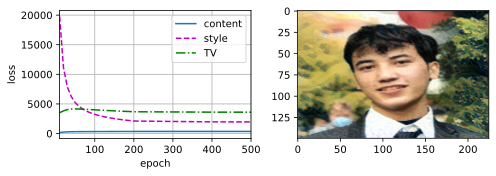

In [345]:
#@ TRAINING THE MODEL: 
device, image_shape = d2l.try_gpu(), (150, 225)                                  # Initialization of Parameters. 
net = net.to(device)                                                             # Initialization of Neural Network Model. 
content_X, contents_Y = get_contents(image_shape, device)                        # Extracting Content Features. 
_, styles_Y = get_styles(image_shape, device)                                    # Extracting Style Features. 
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)          # Training the Model.
save_fig("styletransfer01")

Saving Figure styletransfer02


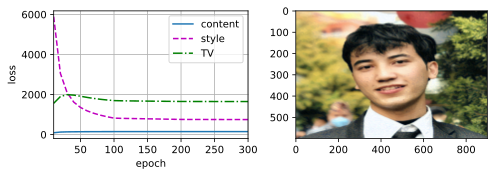

In [347]:
#@ TRAINING THE MODEL: 
device, image_shape = d2l.try_gpu(), (600, 900)                                  # Initialization of Parameters. 
net = net.to(device)                                                             # Initialization of Neural Network Model. 
content_X, contents_Y = get_contents(image_shape, device)                        # Extracting Content Features. 
_, styles_Y = get_styles(image_shape, device)                                    # Extracting Style Features. 
output = train(content_X, contents_Y, styles_Y, device, 0.01, 300, 100)          # Training the Model. 
save_fig("styletransfer02")